In [21]:
# first make sure the input data are good 
import numpy as np 
import os 
import sys
from scipy.stats import zscore
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, make_scorer, f1_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_validate, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import shap
if sys.platform == 'darwin':
    print("Current system is macOS")
    main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
elif sys.platform == 'linux':
    print("Current system is Ubuntu")
    main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
else:
    print("Current system is neither macOS nor Ubuntu")
    
sys.path.append(main_fold_path)    
os.chdir(main_fold_path)
from utils.hyperopt_utils import get_best_hyperparameters, get_best_hyperparameters_skf_inside_loocv_monitoring_recall_bacc

from utils.fnirs_utils import print_md_table_val_test_AUC

Current system is macOS


In [22]:
fold = 'allData/prognosis_mix_hb/pretreatment_response'
data = np.load(fold + '/hb_data.npy')
label = np.load(fold + '/label.npy')

print(data.shape , label.shape)

(64, 52, 2500) (64,)


In [ ]:
print(data.shape)
hbo = data[:, :, 0::2]#.copy()
hbr = data[:, :, 1::2] #.copy()
print(hbr.shape)


def compare_signals(signal1, signal2):
    correlation = np.corrcoef(signal1, signal2)[0, 1]
    return correlation
def set_to_zero_if_std_greated_than_threshold(data, threshold):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if np.std(data[i,j,:]) > threshold:
                data[i,j,:] = 0
    return data
def set_to_zero_if_similarity_lower_than_threshold(data, compared_data, threshold):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            similarity = compare_signals(data[i,j,:], compared_data)
            if similarity < threshold:
                data[i,j,:] = 0
    return data
def average_neighbour_channel(data, adj_matrix):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data[i, j] = np.mean(data[i, adj_matrix[j] == 1], axis=0)
    return data 



data.shape

hbr_std_threshold = hbo_std_threshold = 0.1
hbr_similiarity_threshold = hbo_similiarity_threshold = 0

# hbo = set_to_zero_if_std_greated_than_threshold(hbo, hbo_std_threshold)
# mean_hbo = np.mean(hbo, axis=(0,1))
# hbo = set_to_zero_if_similarity_lower_than_threshold(hbo, mean_hbo, hbo_similiarity_threshold)


# hbr = set_to_zero_if_std_greated_than_threshold(hbr, hbr_std_threshold)
mean_hbr = np.mean(hbr, axis=(0,1))
# hbr = set_to_zero_if_similarity_lower_than_threshold(hbr, mean_hbr, hbr_similiarity_threshold)
# hbr = average_neighbour_channel(hbr, adj_matrix)

plot_data = hbo
plot_mean_data = mean_hbr
channel_bad_count = {}
"""

{
    
    ch1: 0 + std(subject, ch1) ++++++
    ch2: 0 ...
}
"""
for i in range(52):
    channel_bad_count[i] = 0
for subject in range(hbo.shape[0]):#
    fig, axs = plt.subplots(7,8, figsize=(20,20))
    for i in range(52):
        x = i//8 
        y = i%8
        axs[x,y].plot(plot_data[subject, i])
        std = np.std(plot_data[subject, i])
        if std > 1: channel_bad_count[i] += std
        similarity = compare_signals(plot_data[subject, i], plot_mean_data)
        LABEL_I = label[subject]
        axs[x,y].set_title('CH - {} std:{:0.2f} label - {}'.format(i+1, std, LABEL_I))
    plt.tight_layout()

{0: 12.075003758782804, 1: 4.353099051089581, 2: 4.650482461681281, 3: 8.81376953747912, 4: 10.53449825451683, 5: 6.1618508916651, 6: 10.114169415348947, 7: 7.260036192176417, 8: 13.120642606371227, 9: 22.937057592232847, 10: 20.834385825456113, 11: 8.295860067374804, 12: 1.6538614583045363, 13: 3.2731992904802514, 14: 1.781777254281123, 15: 0, 16: 3.1513287837359454, 17: 2.9649814413920583, 18: 3.7117418434087126, 19: 15.529918455920596, 20: 17.749769984068017, 21: 18.091755739733284, 22: 1.5018283460900053, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 10.149421445855156, 30: 28.773016542185044, 31: 15.810886374154183, 32: 12.94718198781814, 33: 0, 34: 2.135803193965809, 35: 0, 36: 0, 37: 2.8215108874064248, 38: 0, 39: 2.29965608506487, 40: 16.071469309270434, 41: 31.13594330956923, 42: 12.277903591328528, 43: 12.507251735238412, 44: 9.110334808695411, 45: 0, 46: 0, 47: 10.159573758768673, 48: 2.8039316799842107, 49: 1.0066404753927714, 50: 2.889601082530034, 51: 13.643250932020742}


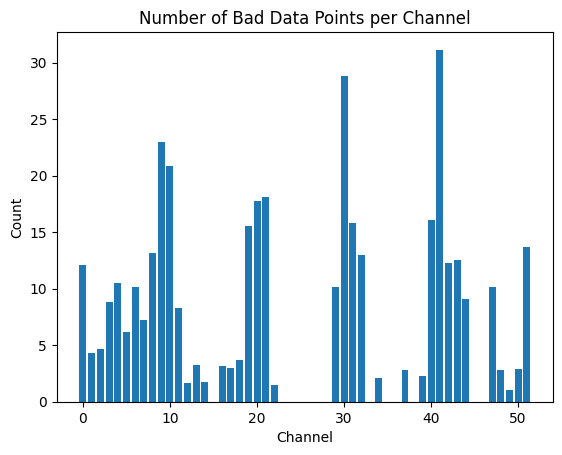

In [32]:
print(channel_bad_count)

plt.bar(channel_bad_count.keys(), channel_bad_count.values())
plt.xlabel('Channel')
plt.ylabel('Count')
plt.title('Number of Bad Data Points per Channel')
plt.show()


In [33]:
from matplotlib import cm

def gradientbars(bars,ydata,cmap):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    ax.axis(lim)
    for bar in bars:
        bar.set_facecolor("none")
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.atleast_2d(np.linspace(0,1*h/max(ydata),256)).T
        ax.imshow(grad, extent=[x,x+w,y,y+h], origin='lower', aspect="auto", 
                  norm=cm.colors.NoNorm(vmin=0,vmax=1), cmap=plt.get_cmap(cmap))

def get_fnirs_channel_colors(ranked_channel):
    colors = []
    # asign color to channel 
    dpc_color = 'lightblue'
    stg_color = 'purple'
    vpc_color = (1.0, 0.5, 0.0)
    mpc_color = (1.0, 0.64, 0.0)
    psfc_color = 'green'

    # Posterior superior frontal cortex
    PSFC_ch = ['C9', 'C10', 'C20', 'C21', 'C1', 'C2', 'C11', 'C12'] # left_pSFC_location = ['C9', 'C10', 'C20', 'C21'] , right_pSFC_location = ['C1', 'C2', 'C11', 'C12']

    # Dorsolateral prefrontal cortex
    DPC_ch = ['C7','C8', 'C17', 'C18', 'C19', 'C28', 'C29', 'C3', 'C4', 'C13', 'C14', 'C15', 'C24', 'C25']# left_DPC_location = ['C7','C8', 'C17', 'C18', 'C19', 'C28', 'C29'], right_DPC_location = ['C3', 'C4', 'C13', 'C14', 'C15', 'C24', 'C25']

    #Superior temporal gyrus
    STG_ch = ['C22', 'C23', 'C32', 'C33', 'C43', 'C44', 'C30', 'C31', 'C41', 'C42', 'C51', 'C52'] #left_STG_location = ['C22', 'C23', 'C32', 'C33', 'C43', 'C44'], right_STG_location = ['C30', 'C31', 'C41', 'C42', 'C51', 'C52']

    # Ventrolateral prefrontal cortex
    VPC_ch = ['C34', 'C35', 'C45', 'C46','C39', 'C40', 'C49', 'C50'] # left_VPC_location = ['C34', 'C35', 'C45', 'C46'], right_VPC_location = ['C39', 'C40', 'C49', 'C50']

    # Medial prefrontal cortex
    MPC_location = ['C5', 'C6', 'C16', 'C26', 'C27', 'C36', 'C37', 'C38', 'C47', 'C48']  


    for ch in ranked_channel:
        ch_name = 'C' + str(ch+1) 
        if ch_name in PSFC_ch:
            colors.append(psfc_color)
        elif ch_name in DPC_ch:
            colors.append(dpc_color)
        elif ch_name in STG_ch:
            colors.append(stg_color)
        elif ch_name in VPC_ch:
            colors.append(vpc_color)
        elif ch_name in MPC_location:
            colors.append(mpc_color)
        else:
            print('ch not found', ch_name)
            colors.append('grey')
            
    return colors

        
def show_ranked_shap_channel_importance(data):
    
    # Calculate both mean and standard deviation along the specified axes
    channel_importance_mean = np.mean(data, axis=(0))
    channel_importance_std = np.std(data, axis=(0))

    # Ranking the channels by their importance (mean values)
    ranked_channel = np.argsort(channel_importance_mean) 
    ranked_channel = ranked_channel[::-1]
    print("Ranked channels by importance:", ranked_channel)

    # 
    ranked_channel_x = ['C' + str(i+1) for i in ranked_channel]
    ranked_channel_importance = channel_importance_mean[ranked_channel]
    ranked_channel_importance_std = channel_importance_std[ranked_channel]
    error = [np.zeros(channel_importance_std.shape), ranked_channel_importance_std]  # First row zeros, second row stds

    fig, ax = plt.subplots(figsize=(20,10))

    shap_bar = ax.bar(ranked_channel_x, ranked_channel_importance, yerr=error, capsize=5, edgecolor='grey')



    yticks = [0, 0.5, 1, 1.2]
    yticklabels = ['0', '0.5', '1', ' ']
    # yticks = [0, 1e-4, 2e-4, 3e-4]
    # yticklabels = ['0', '0.0001', '0.0002', '0.0003']
    plt.yticks(yticks, yticklabels,fontsize=20)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().yaxis.get_offset_text().set_fontsize(15)

    # plt.ylim(0, 0.00025)  # Optional: Set y-axis limits if necessary

    plt.xticks(np.arange(52), fontsize=15, rotation=45, fontweight='bold')  # Optional: Improve x-axis readability if necessary
    plt.ylabel('mean |SHAP value|',fontsize=15, fontweight='bold')
    plt.xlabel('Ranked channel',fontsize=15, fontweight='bold')
    plt.title('Average Channel Importance', fontweight='bold', fontsize=20)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

    gradientbars(shap_bar, ranked_channel_importance, 'viridis_r')


    # marker the region color of each channel
    colors = get_fnirs_channel_colors(ranked_channel)
    y_marker_position = 1.2 * 0.95
    for bar, color in zip(shap_bar, colors):
        # Calculate the center of the bar
        center_x = bar.get_x() + bar.get_width() / 2
        
        # Use scatter to add a colored square marker
        ax.scatter(center_x, y_marker_position, s=400, color=color, marker='s', zorder=3)

    plt.show()


In [59]:
plot_channel_bad_count.shape

(2, 52)

Ranked channels by importance: [41 30  9 10 21 20 40 31 19 51  8 32 43 42  0  4 47 29  6 44  3 11  7  5
  2  1 18 13 16 17 50 37 48 39 34 14 12 22 49 36 15 35 46 45 23 24 26 27
 28 38 33 25]


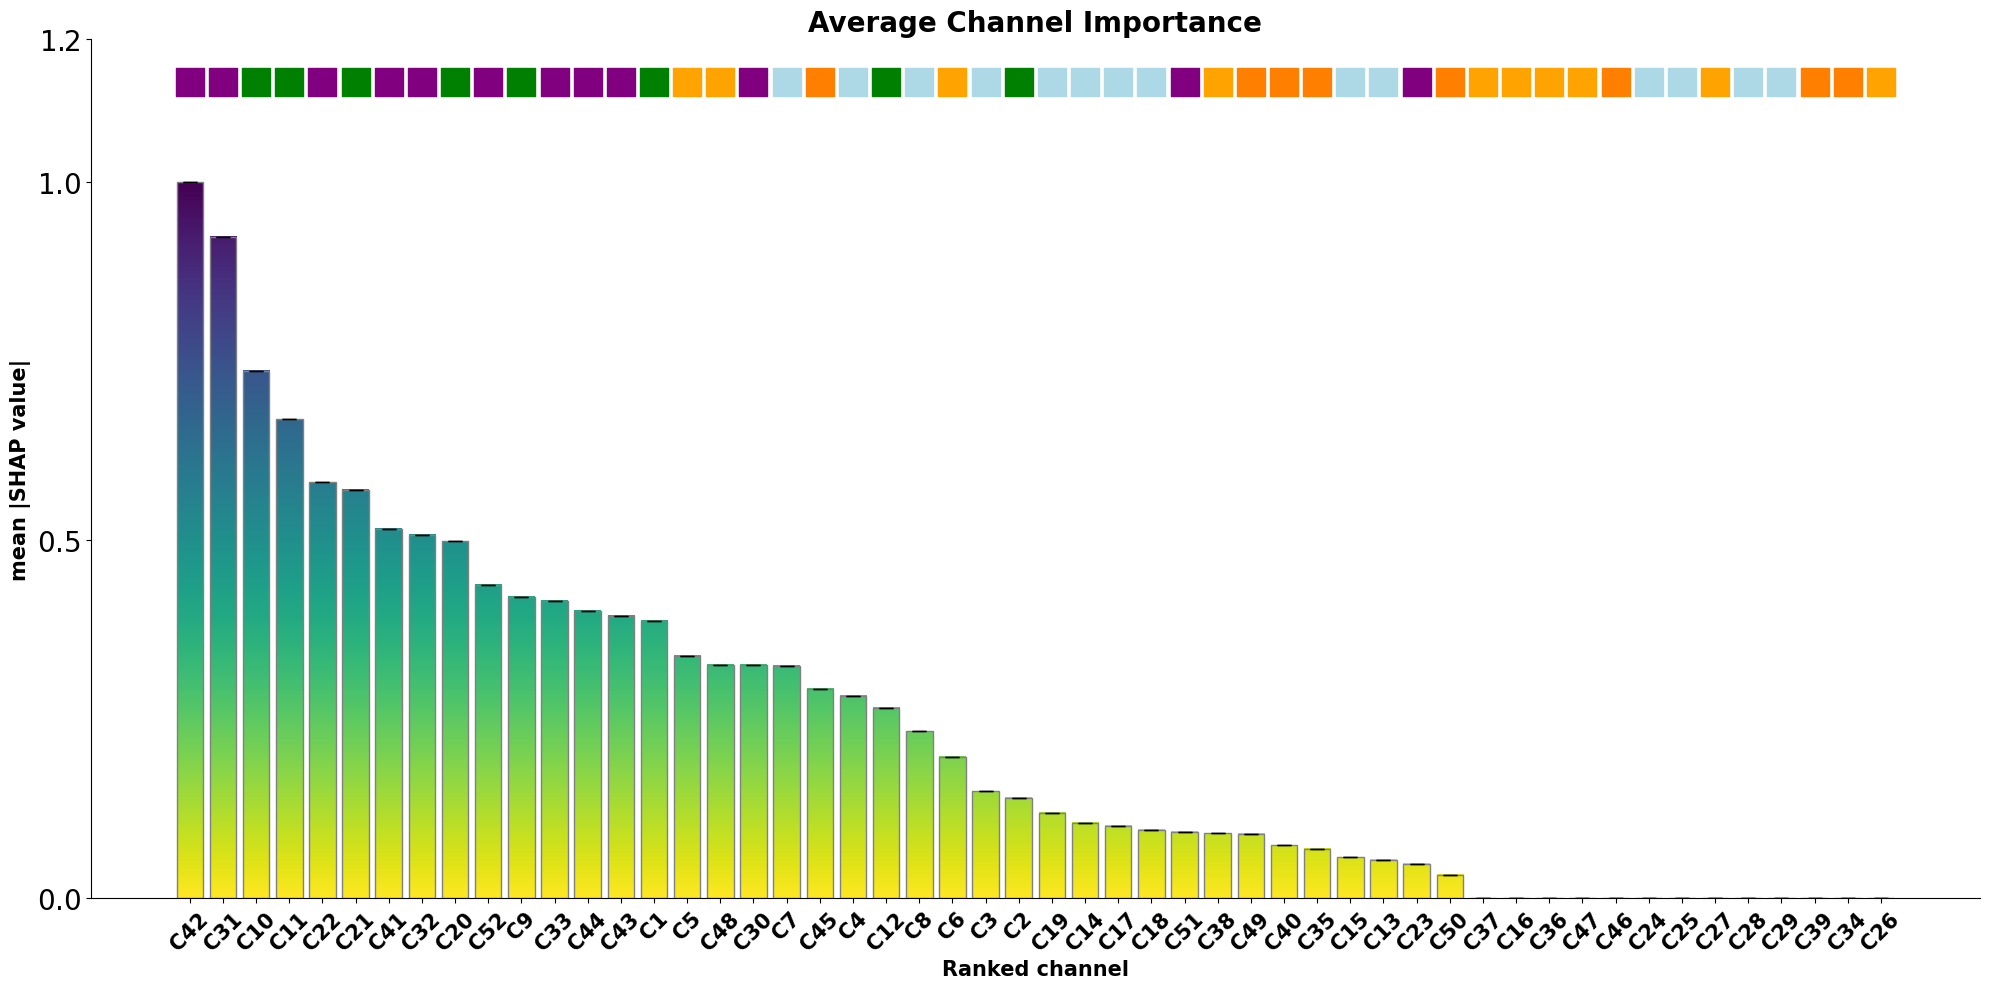

In [34]:
from matplotlib.ticker import ScalarFormatter
plot_channel_bad_count = np.array([list(channel_bad_count.values()) for i in range(2)])
plot_channel_bad_count = plot_channel_bad_count / np.max(plot_channel_bad_count)
show_ranked_shap_channel_importance(plot_channel_bad_count)

# 查看具体每个通道的结果

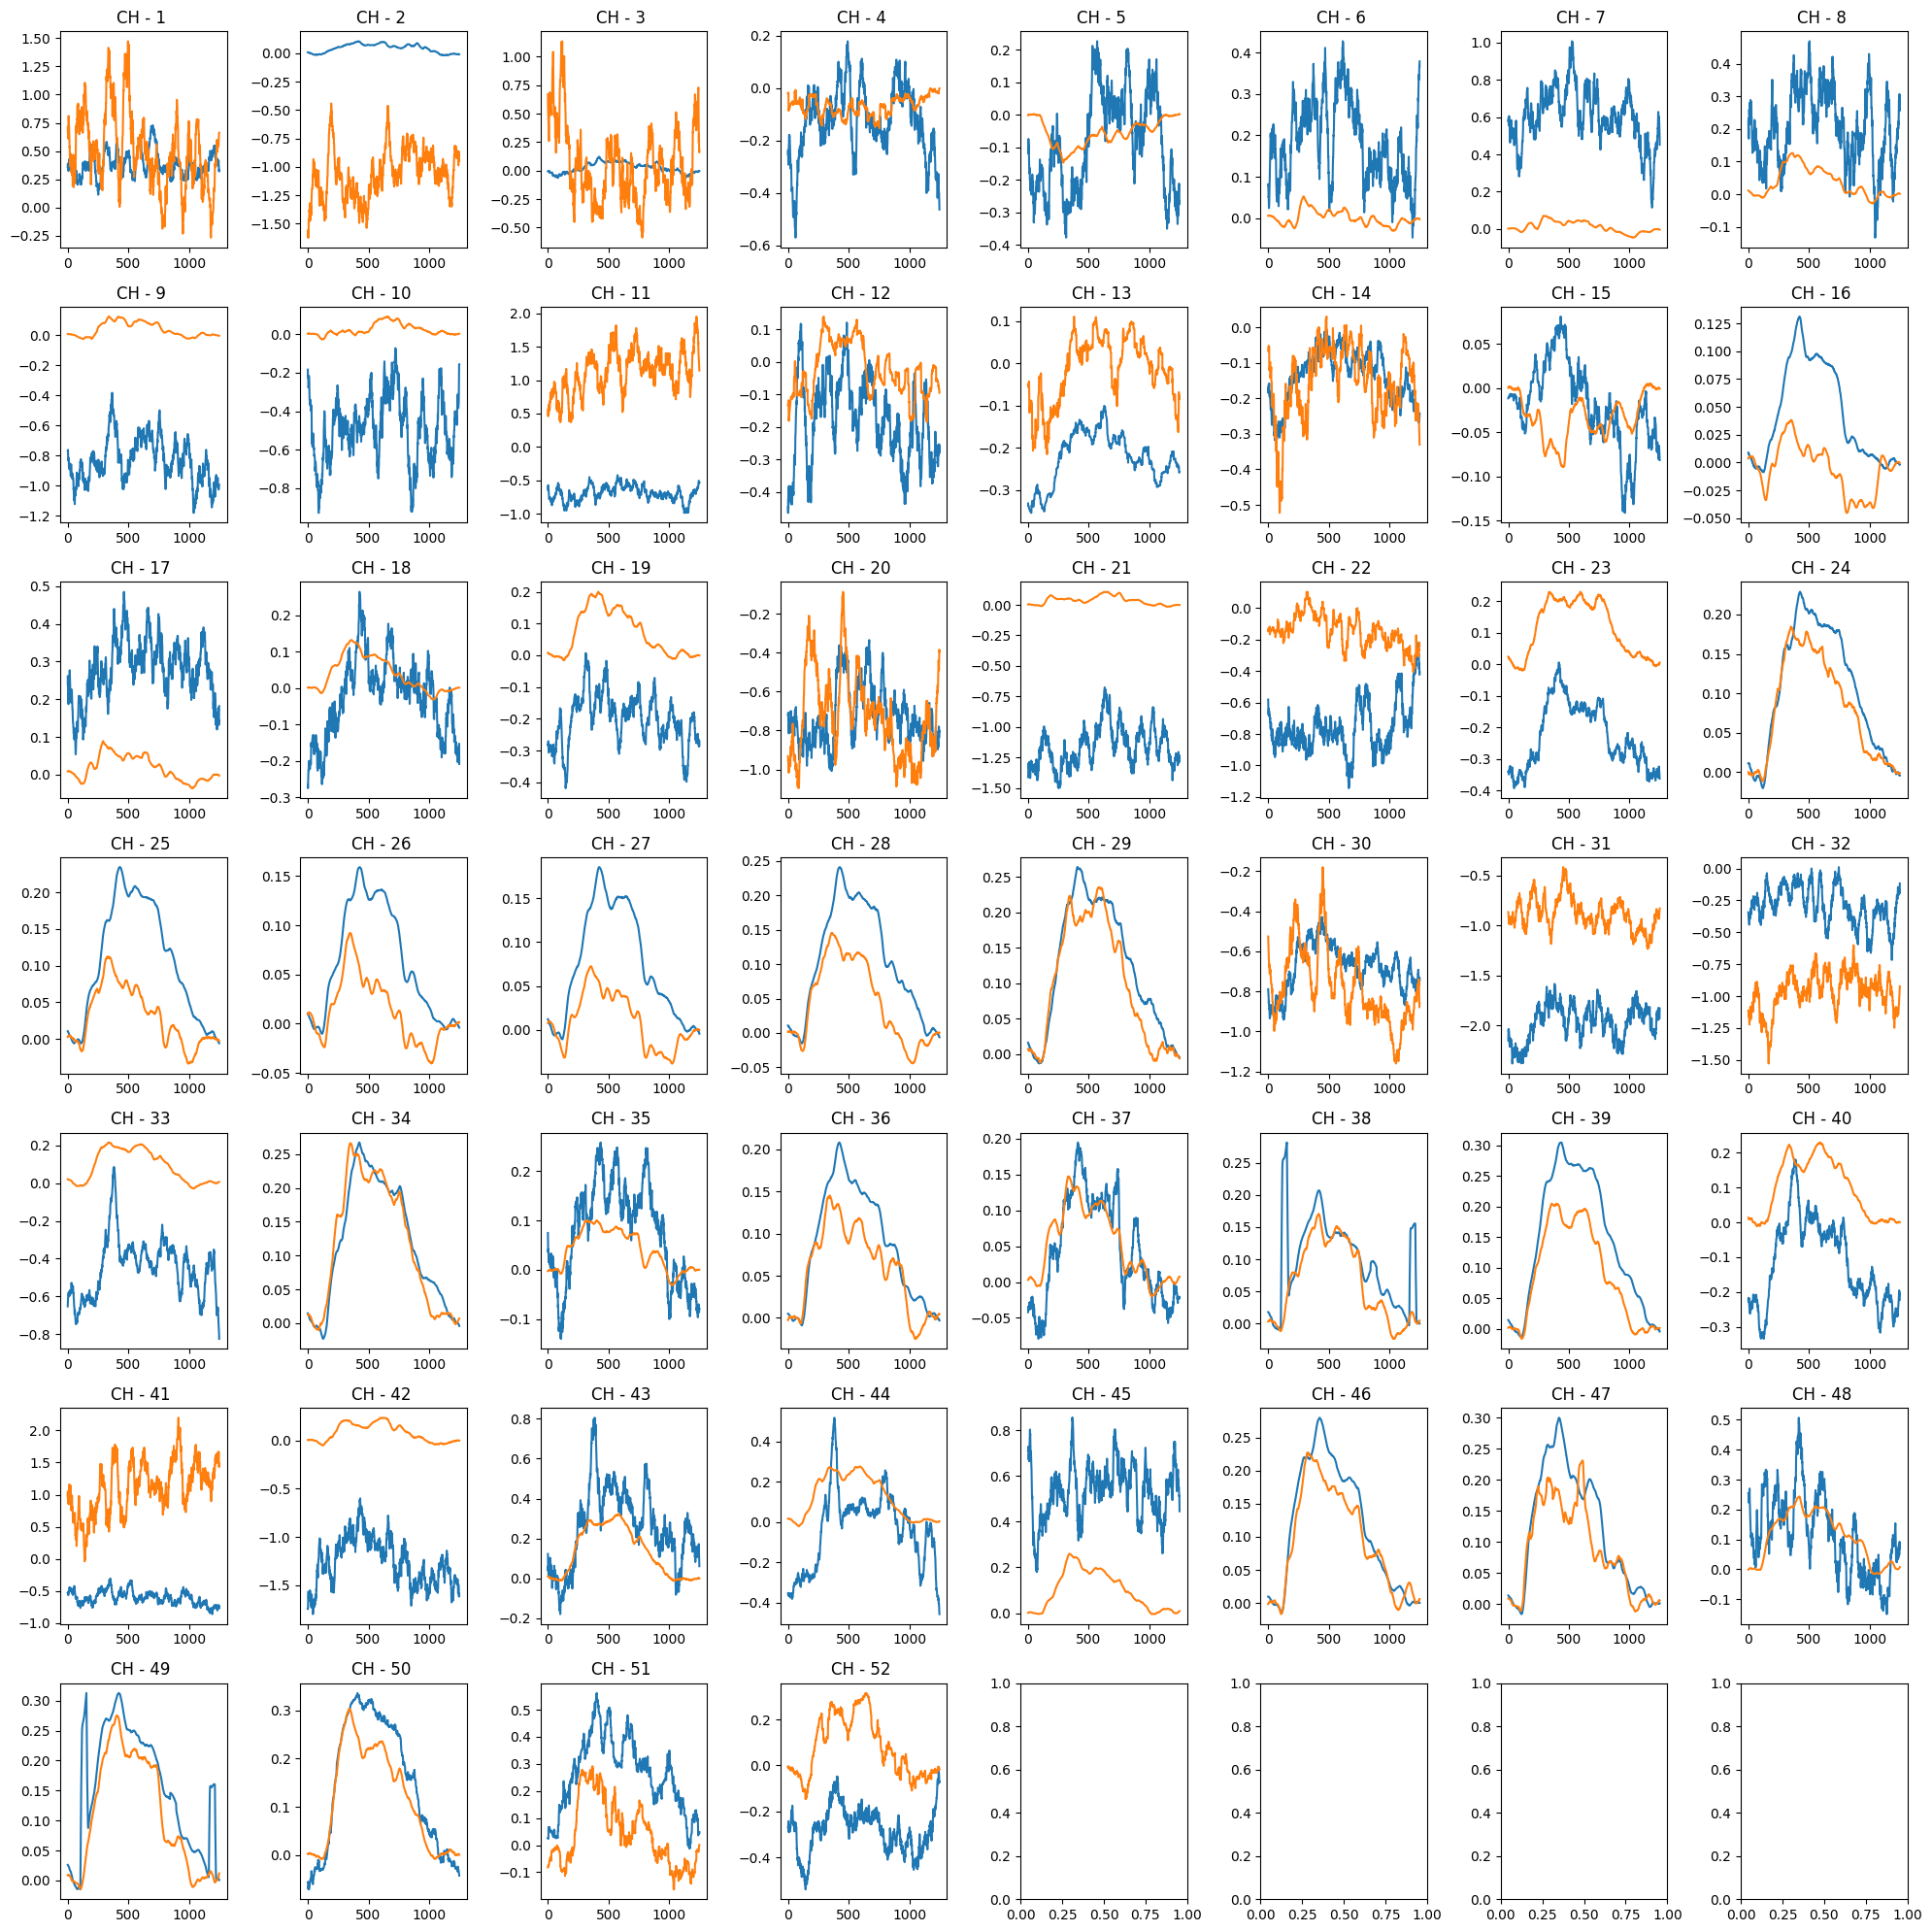

In [17]:
import numpy as np

hbr_std_threshold = hbo_std_threshold = 0.1
hbr_similiarity_threshold = hbo_similiarity_threshold = 0

# hbo = set_to_zero_if_std_greated_than_threshold(hbo, hbo_std_threshold)
# mean_hbo = np.mean(hbo, axis=(0,1))
# hbo = set_to_zero_if_similarity_lower_than_threshold(hbo, mean_hbo, hbo_similiarity_threshold)


# hbr = set_to_zero_if_std_greated_than_threshold(hbr, hbr_std_threshold)
mean_hbr = np.mean(hbr, axis=(0,1))
# hbr = set_to_zero_if_similarity_lower_than_threshold(hbr, mean_hbr, hbr_similiarity_threshold)
# hbr = average_neighbour_channel(hbr, adj_matrix)

plot_data = hbo
plot_mean_data = mean_hbr
channel_bad_count = {}
for i in range(52):
    channel_bad_count[i] = 0
fig, axs = plt.subplots(7,8, figsize=(20,20))

channel_effect_size = []
for ch in range(hbo.shape[1]):
    x = ch//8 
    y = ch%8
    non_respond = plot_data[:, ch][label == 0]
    respond = plot_data[:, ch][label == 1]
    
    non_respond_mean = np.mean(non_respond)
    respond_mean = np.mean(respond)
    non_respond_std = np.std(non_respond)
    respond_std = np.std(respond)

    effect_size = (non_respond_mean - respond_mean) / np.sqrt((non_respond_std**2 + respond_std**2) / 2)

    channel_effect_size.append(effect_size)
    
    
    axs[x,y].plot(np.mean(non_respond, axis=0), label = 'Nonresponders')
    axs[x,y].plot(np.mean(respond, axis=0), label = 'Responders')
    # std = np.std(plot_data[subject, ch])
    axs[x,y].set_title('CH - {} '.format(ch+1))
    plt.tight_layout()

#  How Hitachi process the data?

In [18]:
channel_effect_size = np.abs(np.array(channel_effect_size))
channel_effect_size = np.array([list(channel_effect_size), list(channel_effect_size)])

Ranked channels by importance: [ 1 40 20 26 24 15 41 44 25 10 27 50 22 18  8 30 21 16 38 32  6 39 31  9
 35 12  5 23 48 46 34 28 37 45 49 17  7 43 51 42 11  0  3 14 29  4  2 36
 13 33 47 19]


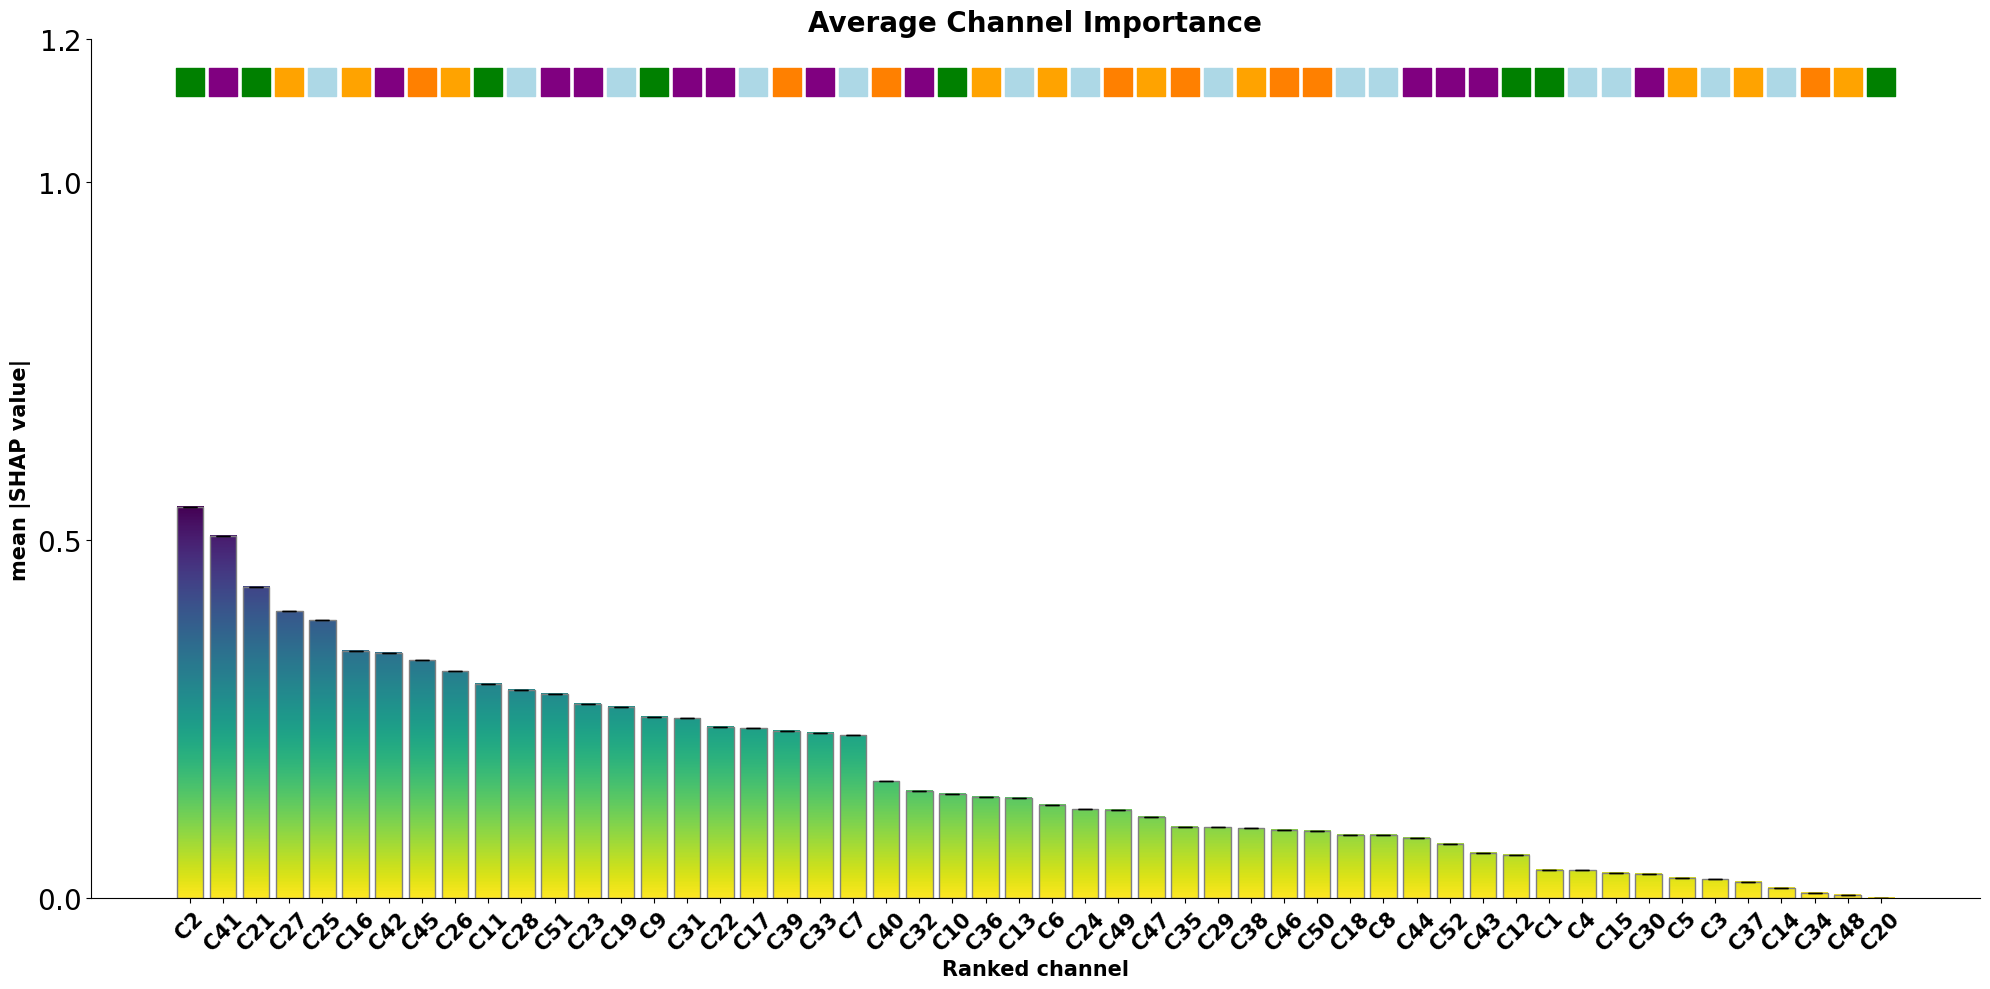

In [19]:
show_ranked_shap_channel_importance(channel_effect_size)